# Churn Classification Model

### Import

In [19]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [3]:
data = pd.read_csv('../dataset/findata_challenge_train.csv')

In [4]:
data.head(3)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x116,x117,x118,x119,x120,x121,x122,x123,x124,y
0,0.067563,-2.172492,-1.713774,-0.146854,-0.685219,-0.933838,4.0,2.0,-4.476051,-1.472306,...,4.607926,52.0,1.0,0.773809,0.766531,6.307142,9.074515,-2.694049,0.330964,0
1,0.099622,0.584803,-6.089758,-0.252186,-0.334912,-4.671281,4.0,2.0,-0.387076,-0.664552,...,15.889763,53.0,1.0,7.065852,0.994304,-0.028411,-21.472850,5.626095,1.293455,0
2,0.648421,3.881137,0.961359,0.217361,-1.471850,-0.975352,5.0,1.0,-0.850146,-4.011487,...,13.770410,53.0,1.0,-8.598553,-2.958302,-12.784030,-36.855873,0.356093,1.499790,0


In [5]:
tot_obs = len(data)
tot_feat = len(data.columns) - 1
tot_num_feat = len(data._get_numeric_data().columns) - 1
tot_cat_feat = tot_feat - tot_num_feat


print(f'Data details')
print('-'*22)
print(f'Total observation    : {tot_obs}')
print(f'Total features       : {tot_feat}')
print(f'Numerical features   : {tot_num_feat}')
print(f'Categorical features : {tot_cat_feat}')

Data details
----------------------
Total observation    : 100000
Total features       : 125
Numerical features   : 120
Categorical features : 5


# Handling Missing Values

Check missing value percentage for each column

In [6]:
perc_missing = (data.isna().sum()/len(data)).sort_values(ascending=False)*100
perc_missing = pd.DataFrame(
               {'col_name': perc_missing.index, 'perc (%)': perc_missing.values})
print(perc_missing.head(10))
sns.boxplot(data=perc_missing, x='perc (%)')

  col_name  perc (%)
0      x45     0.159
1      x70     0.159
2      x14     0.156
3      x72     0.149
4     x110     0.148
5      x75     0.146
6      x13     0.145
7     x112     0.142
8      x10     0.142
9      x86     0.141


<AxesSubplot:xlabel='perc (%)'>

In [7]:
# Check missing values row-wise
data.isna().sum(axis=1).describe()

count    100000.00000
mean          0.16024
std           0.36683
min           0.00000
25%           0.00000
50%           0.00000
75%           0.00000
max           1.00000
dtype: float64

As we can see, there's no column that has significant missing values ***(max is 0.159% missing)***. 

And as we almost don't know each context of the column, so we can just change the missing value with `median` for **numerical value** and `mode` for **categorical value**.

In [8]:
# Get numerical column and categorical column
num_col = data._get_numeric_data().columns[:-1]
cat_col = data.drop(num_col, axis=1).columns[:-1]

In [9]:
for col in cat_col:
    data[col] = data[col].fillna(data[col].mode()[0])

for col in num_col:
    data[col] = data[col].fillna(data[col].median())

In [10]:
perc_missing = (data.isna().sum()/len(data)).sort_values(ascending=False)*100
perc_missing = pd.DataFrame({'col_name':perc_missing.index, 'perc (%)':perc_missing.values})
perc_missing.describe()

,perc (%)
count,126.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


Missing value handled, now there's no missing value left.

# Exploratory Data Analysis

## Categorical Data

Since there's only 5 column (total categorical feature) that we can guess the meaning of, we can focus the EDA on those column first. Let's see each of their distribution and also their relation to the target value (churn or not).

In [11]:
categorical_df = data[cat_col].copy()
categorical_df = categorical_df.merge(data.iloc[:, -1], left_index=True, right_index=True)

Plot the categorical data to see the distribution and see if there's something interesting (like anomaly or anything).

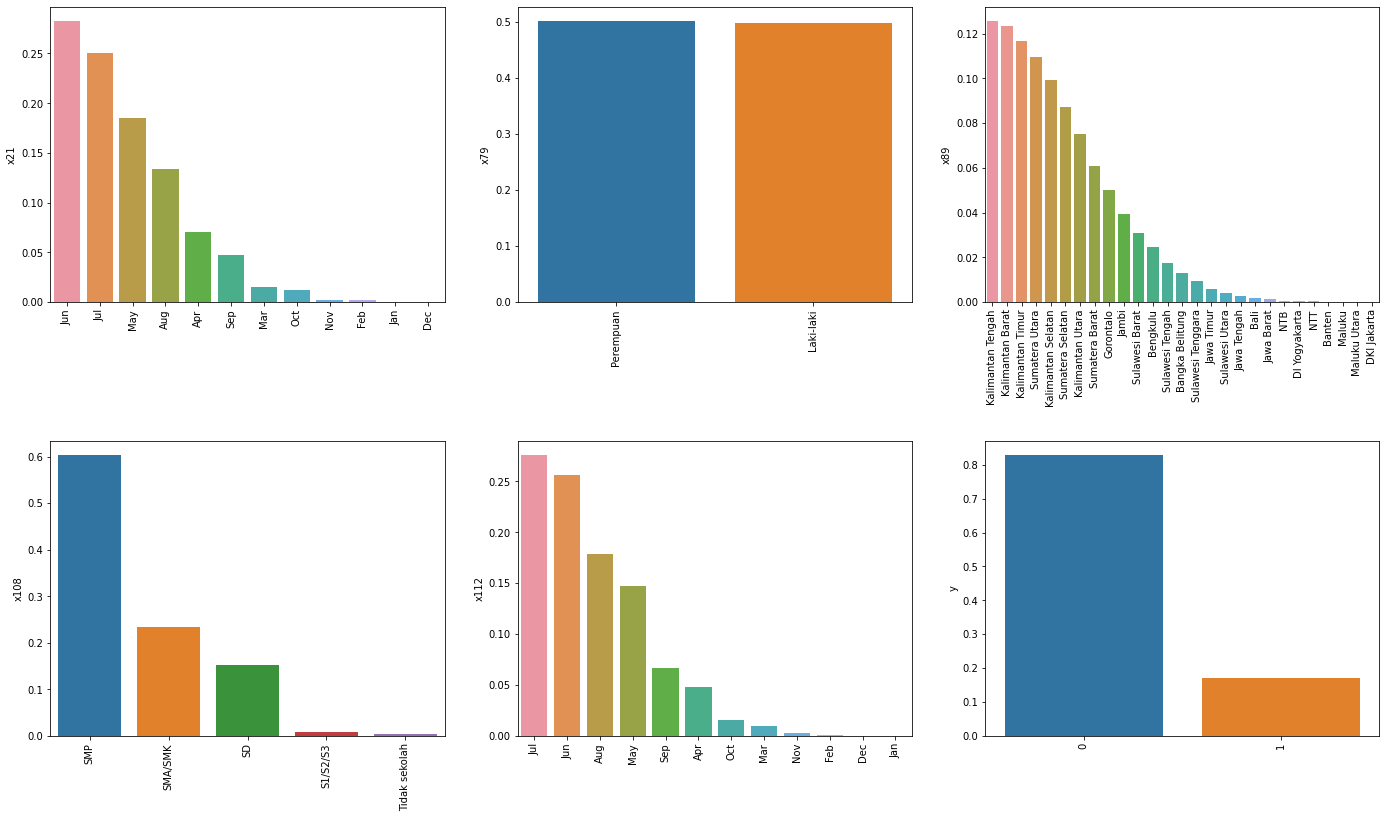

In [16]:
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(20)


for i, col in enumerate(categorical_df.columns):
    s = categorical_df[col].value_counts(normalize=True)
    fig.add_subplot(int(f'23{i+1}'))
    fig.tight_layout(pad=3)
    sns.barplot(x=s.index, y=s)
    plt.xticks(rotation=90)

plt.show()

From the graph above, we can see a glimpse of what the customer demography looks like. Interestingly, most of the "people" are not from java or DKI Jakarta. And from the education level which mostly occupied by "SMP", we can expect that the record mostly from people that lives in sub-urban area.

Other thing is, we can see there's 2 feature that resemble month, but we can assume that they was not redundant, meaning they have different meaning (given the different distribution).

And also, we can see there's a class imbalance in the dataset (around 4:1). The majority is class 0 (churn).

Lastly, as we can see that gender has a low entropy, that's because there's only two option. But instead of removing gender attribute, where it's in most cases really useful, we can calculate the information gain or combininig them with another feature (let's say gender-education level).

--------------------

Next up, to see each categorical feature correlation with the target value. Are the target ***"independent"*** of one of the feature, or it is ***"not independent"***. We can use qualitative analysis (chi2 contingecy table) to see the correlation with p-value, and we can use information gain to see the entropy.

-------
H0: Target are indpendent.

H1: Target are not independent.

In [48]:
feature_list = [f for f in categorical_df.columns[:-1]]
p_val_list = []
for feature in feature_list:
    cr = pd.crosstab(categorical_df[feature], categorical_df.y)
    ch = chi2_contingency(cr)
    p_val = ch[1]
    p_val_list.append(p_val)

alpha = 0.05
chi2_test = pd.DataFrame({'feature': feature_list, 'p_val': p_val_list})
chi2_test['result'] = np.where(chi2_test.p_val < alpha,
                               'HO Reject', 'Accept H0')
chi2_test

,feature,p_val,result
0,x21,4.370747e-83,HO Reject
1,x79,3.425007e-01,Accept H0
2,x89,1.234964e-01,Accept H0
3,x108,9.800564e-01,Accept H0
4,x112,4.920055e-01,Accept H0


From the chi2 squared test, we can see that feature x21 is the only feature that are "not independent". But we need to also look at the entropy using information gain.

Next step:
1. information gain
2. transforming gender
3. calculating information gain lagi
5. high correlation between feature -> pearson/spearman.
6. student t-test
7. anova-f
8. feature engineering
9. base model logit
10. base model xgboost
11. model with transformed feature
12. hyperparameter tuning
13. back test

## Numerical Data

Lookout for numerical data that's not normalized.

In [14]:
# Get unnormalized numerical data
s = (data[num_col].min() > 0)
not_norm_col = s[s].index
nanorm = data[not_norm_col]

In [15]:
nanorm.describe()

,x63,x80,x93,x96,x117
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000
mean,13.275090,2018.04551,2009.753330,12.632470,50.012680
std,3.102375,0.84918,2.339141,2.799323,6.887448
min,1.000000,2015.00000,2000.000000,1.000000,21.000000
25%,11.000000,2018.00000,2008.000000,11.000000,45.000000
50%,13.000000,2018.00000,2010.000000,13.000000,50.000000
75%,15.000000,2019.00000,2011.000000,14.000000,54.000000
max,27.000000,2021.00000,2020.000000,27.000000,80.000000
